In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn.svm import SVC, LinearSVC
import imblearn

df = pd.read_excel("Crunchbase_2005-2013.xls", index_col = 'Organization Name', na_values=['nan'])

df.shape

(7566, 123)

In [2]:
#Decision Matrix Function
def confusion_matrix_plot(conf_mat):
    n = len(conf_mat)
    plt.imshow(conf_mat, cmap='Blues', extent=[-0.5, n-0.5, -0.5, n-0.5])
    
    for i in range(n):
        for j in range(n):
            plt.text(i, j, conf_mat[n-j-1, i], ha='center', va='center')
    
    plt.colorbar()
    plt.xticks(range(n))
    plt.yticks(range(n), range(n-1, -1, -1))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.plot

In [3]:
df = df[df.columns[df.isnull().mean() < 0.5]]
df.shape

(7566, 60)

In [4]:
#Drop all columns that may not be needed
column_drop = ["Phone Number", 'Full Description', 'Organization Name URL', 'Phone Number', 'Contact Email', 'LinkedIn',
       'Facebook', 'Twitter', 'Website', 'CB Rank (Organization)', 'Last Funding Amount Currency', 'Acquisition Type',
       'Last Funding Amount Currency (in USD)', 'Number of Employees', 'Number of Lead Investors', 'Number of Investors',
       'Trend Score (7 Days)', 'Trend Score (30 Days)', 'Total Equity Funding Amount Currency', 'Last Equity Funding Amount Currency',
       'Last Equity Funding Amount Currency (in USD)', 'Total Equity Funding Amount Currency', "Industries", 'CB Rank (Company)',
       'Total Equity Funding Amount Currency (in USD)', 'Total Funding Amount Currency', 'Description', "Transaction Name", 
       'Total Funding Amount Currency (in USD)', 'Exit Date Precision', 'Founded Date Precision', 'Announced Date', 'Announced Date Precision',
       'Total Equity Funding Amount Currency', 'Total Funding Amount Currency', 'Last Funding Amount Currency',
       'Trend Score (90 Days)', 'Transaction Name URL', 'Acquired by', 'Company Type',
       'Acquired by URL', 'BuiltWith - Active Tech Count', 'Number of Articles', 'Founders', 'Number of Founders',
       'G2 Stack - Total Products Active', 'Headquarters Location', 'Headquarters Regions', 'Exit Date',
        'Last Equity Funding Amount', 'Last Equity Funding Type', 'Total Equity Funding Amount','Total Funding Amount',
        'Last Funding Amount', 'Operating Status']
       
df = df.drop(axis = 1, columns = column_drop)

df.isnull().sum()

Estimated Revenue Range     2807
Founded Date                   0
Industry Groups               12
Number of Funding Rounds       0
Funding Status               512
Last Funding Date              0
Last Funding Type              0
Top 5 Investors             1060
Acquisition Status             0
IPO Status                     0
dtype: int64

In [5]:
df.dtypes

Estimated Revenue Range             object
Founded Date                datetime64[ns]
Industry Groups                     object
Number of Funding Rounds             int64
Funding Status                      object
Last Funding Date           datetime64[ns]
Last Funding Type                   object
Top 5 Investors                     object
Acquisition Status                  object
IPO Status                          object
dtype: object

In [6]:
df["IPO Status"].unique()

array(['Private', 'Public', 'Delisted'], dtype=object)

In [7]:
df['Acquisition Status'].unique()

array(['Made Acquisitions', 'Made Acquisitions, Was Acquired',
       'Was Acquired'], dtype=object)

In [8]:
df["Industry Groups"].unique()

array(['Artificial Intelligence, Data and Analytics, Information Technology, Science and Engineering, Software',
       'Content and Publishing, Internet Services, Media and Entertainment, Other',
       'Administrative Services, Financial Services, Software', ...,
       'Commerce and Shopping, Events, Media and Entertainment, Other',
       'Content and Publishing, Data and Analytics, Design, Internet Services, Media and Entertainment, Software',
       'Consumer Electronics, Hardware, Information Technology'],
      dtype=object)

In [9]:
df['Estimated Revenue Range'].unique()

array(['$1B to $10B', '$100M to $500M', '$500M to $1B', '$50M to $100M',
       nan, '$10M to $50M', '$1M to $10M', 'Less than $1M', '$10B+'],
      dtype=object)

In [10]:
df.pivot_table(index=['IPO Status'], aggfunc='size')

IPO Status
Delisted     114
Private     7045
Public       407
dtype: int64

In [11]:
#df.pivot_table(index=['Top 5 Investors'], aggfunc='size')

df["Top 5 Investors"] = df["Top 5 Investors"].str.split(',').fillna(' ')

In [12]:
df.pivot_table(index=['Estimated Revenue Range'], aggfunc='size')

Estimated Revenue Range
$100M to $500M     372
$10B+                9
$10M to $50M      1312
$1B to $10B         58
$1M to $10M       2039
$500M to $1B        57
$50M to $100M      294
Less than $1M      618
dtype: int64

In [13]:
df.pivot_table(index=['Acquisition Status'], aggfunc='size')

Acquisition Status
Made Acquisitions                  1876
Made Acquisitions, Was Acquired     797
Was Acquired                       4893
dtype: int64

In [14]:
#Converting columns to the correct data type
df["Last Funding Date"] = pd.DatetimeIndex(pd.to_datetime(df['Last Funding Date'], unit='s')).year
df["Founded Date"] = pd.DatetimeIndex(pd.to_datetime(df['Founded Date'], unit='s')).year
df['Acquisition Status'] = df['Acquisition Status'].astype(str)
df['Industry Groups'] = df['Industry Groups'].astype(str)

df['Estimated Revenue Range'] = df['Estimated Revenue Range'].astype(str)
df['Estimated Revenue Range'] = df['Estimated Revenue Range'].replace('nan', np.NaN).fillna(' ')
df

,Estimated Revenue Range,Founded Date,Industry Groups,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Type,Top 5 Investors,Acquisition Status,IPO Status
Organization Name,,,,,,,,,,
UiPath,$1B to $10B,2005,"Artificial Intelligence, Data and Analytics, I...",8,Late Stage Venture,2021,Series F,"[Tencent Holdings, Sequoia Capital, T. Rowe ...",Made Acquisitions,Private
Reddit,$100M to $500M,2005,"Content and Publishing, Internet Services, Med...",7,M&A,2021,Series E,"[Tencent Holdings, Sequoia Capital, Andreess...","Made Acquisitions, Was Acquired",Private
Workday,$1B to $10B,2005,"Administrative Services, Financial Services, S...",6,IPO,2011,Series F,"[T. Rowe Price, Morgan Stanley, New Enterpri...",Made Acquisitions,Public
Box,$500M to $1B,2005,"Hardware, Internet Services, Software",12,IPO,2014,Series G,"[General Atlantic, Salesforce Ventures, Tele...",Made Acquisitions,Public
Zillow,$500M to $1B,2005,"Commerce and Shopping, Internet Services, Real...",5,IPO,2012,Post-IPO Equity,"[Benchmark, TCV, PAR Capital Management, Le...",Made Acquisitions,Public
...,...,...,...,...,...,...,...,...,...,...
ActiveNet,,2013,"Data and Analytics, Information Technology, So...",1,M&A,2014,Seed,[BoomStartup],Was Acquired,Private
FriedWire,,2013,Data and Analytics,1,M&A,2000,Venture - Series Unknown,[Enercap Associates],Was Acquired,Private
ReferBright,,2013,Health Care,1,M&A,2013,Seed,"[Founder Friendly Labs, Blueprint Health]",Was Acquired,Private


## Success Metric

In [15]:
#Successfui company metric
df['Class'] = 0

df.loc[(df["Last Funding Date"] >= 2018) | (df["Number of Funding Rounds"] > 7) | 
       (df["IPO Status"] == "Public"),
       'Class'] = 1

In [16]:
#Sum should be 1804, seems like a somewhat accurate distribution
df["Class"].sum()

1804

In [17]:
#list of column values
rev_list = [x for x in df['Estimated Revenue Range'].unique() if str(x) != 'nan']
rev_list

['$1B to $10B',
 '$100M to $500M',
 '$500M to $1B',
 '$50M to $100M',
 ' ',
 '$10M to $50M',
 '$1M to $10M',
 'Less than $1M',
 '$10B+']

In [18]:
#One hot encoding cell 
enc = OneHotEncoder(sparse=False)

IPO_status = df[["IPO Status"]]
Acquisition_status = df[["Acquisition Status"]]
Estimated_Revenue = df[["Estimated Revenue Range"]]
IPO_1hot = enc.fit_transform(IPO_status)
Acquisition_status_1hot = enc.fit_transform(Acquisition_status)
Revenue_1hot = enc.fit_transform(Estimated_Revenue)
IPO_df = pd.DataFrame(columns = ['Delisted', 'Private', 'Public'], data = IPO_1hot, index = df.index)
Acquisition_df = pd.DataFrame(columns = df["Acquisition Status"].unique(), data = Acquisition_status_1hot, index = df.index)
Revenue_df = pd.DataFrame(columns = enc.get_feature_names(['Revenue']), data = Revenue_1hot, index = df.index)

In [19]:
#Add one hot dataframes to exisiting df
df = df.drop(['IPO Status', 'Acquisition Status', 'Estimated Revenue Range'], axis=1)
df = pd.concat([IPO_df, df], axis=1)
df = pd.concat([Acquisition_df, df], axis=1)
df = pd.concat([Revenue_df, df], axis=1)

In [20]:
#Possible vectorizing of industry terms
tf_idf = TfidfVectorizer(ngram_range = (1, 1), stop_words='english')

bow = tf_idf.fit_transform(df['Industry Groups']).toarray()

vect = pd.DataFrame(bow, columns=tf_idf.get_feature_names(), index=df.index)
df = pd.concat([vect, df], axis=1)

In [21]:
df.drop('Revenue_ ', axis=1, inplace=True)

#### Holdout

In [22]:
hf = df[-15:]
hf

,administrative,advertising,agriculture,analytics,apparel,apps,artificial,audio,beverage,biotechnology,...,Private,Public,Founded Date,Industry Groups,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Type,Top 5 Investors,Class
Organization Name,,,,,,,,,,,,,,,,,,,,,
Manage My Co-op,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,nan,1,M&A,2014,Seed,[Starve Ups],0
VerbalCare,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Health Care, Information Technology, Software",1,M&A,2013,Grant,[MassChallenge],0
RealTargeting,0.0,0.567423,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Advertising, Internet Services, Sales and Mark...",1,M&A,2013,Seed,[Matthew Novick],0
Sleeker App Studios,0.0,0.000000,0.0,0.000000,0.0,0.73796,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Apps, Mobile, Software",2,Private Equity,2018,Private Equity,[Sparksuite],1
ProMD,0.0,0.000000,0.0,0.000000,0.0,0.63846,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Apps, Health Care, Software",2,M&A,2014,Seed,"[Healthbox, BoomStartup]",0
CloudPress,0.0,0.505051,0.0,0.407692,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Advertising, Data and Analytics, Sales and Mar...",1,M&A,2013,Non-equity Assistance,[Flat6Labs],0
HybridSite Web Services,0.0,0.000000,0.0,0.300154,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Content and Publishing, Data and Analytics, De...",1,M&A,2013,Seed,[LightHouse Ohio],0
Levy Acquisition,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Financial Services, Lending and Investments",1,Seed,2013,Seed,[Jumpstart Ventures],0
Domain Media,0.0,0.482867,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Advertising, Internet Services, Media and Ente...",1,NaN,2014,Equity Crowdfunding,,0


In [23]:
#Select X & y then use undersampling to redistribute the data
from imblearn.under_sampling import RandomUnderSampler

X = df.iloc[:, 0:85]
y = df["Class"]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [24]:
test_precision = []
test_recall = []
training_size = []
train_size = 0.3
results = pd.DataFrame()

for i in range(17):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size = train_size)

    clf = SGDClassifier()
    
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    test_precision.append(precision_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    training_size.append(round(train_size, 3))
    
    train_size += 0.025

results["Test Precision"] = test_precision
results["Test Recall"] = test_recall
results["Train Size"] = training_size
results
max_recall = results.loc[results["Test Recall"].idxmax()]
#print("Best Results")
max_recall

Test Precision    0.665780
Test Recall       0.913625
Train Size        0.550000
Name: 10, dtype: float64

In [25]:
test_size = (1 - max_recall["Train Size"])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = test_size)

# Model Creation

## Random Forest

In [26]:
#Using random forest classifier for feature importance & overall accuracy
clf = RandomForestClassifier(oob_score = True, bootstrap=True)

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training Accuracy:", round(clf.score(X_train, y_train), 4))
print("Test Accuracy:", round(clf.score(X_test, y_test), 4))

Training Accuracy: 0.9627
Test Accuracy: 0.7518


Training Confusion Matrix
Training Precision: 0.9648 Training Recall: 0.9609
              precision    recall  f1-score   support

    Fail (0)       0.96      0.96      0.96       987
 Success (1)       0.96      0.96      0.96       997

    accuracy                           0.96      1984
   macro avg       0.96      0.96      0.96      1984
weighted avg       0.96      0.96      0.96      1984



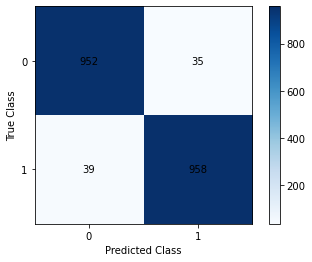

In [27]:
conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

print("Training Confusion Matrix")
confusion_matrix_plot(conf_mat_train)
print(f"Training Precision: {round(precision_score(y_train, y_pred_train),4)} Training Recall: {round(recall_score(y_train, y_pred_train),4)}")
target_names = ['Fail (0)', 'Success (1)']
print(classification_report(y_train, y_pred_train, target_names=target_names))

Test Confusion Matrix
Test Precision: 0.7405 Test Recall: 0.7708
              precision    recall  f1-score   support

    Fail (0)       0.76      0.73      0.75       817
 Success (1)       0.74      0.77      0.76       807

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



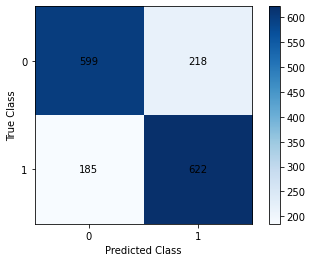

In [28]:
print("Test Confusion Matrix")
confusion_matrix_plot(conf_mat_test)
print(f"Test Precision: {round(precision_score(y_test, y_pred_test),4)} Test Recall: {round(recall_score(y_test, y_pred_test),4)}")
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [29]:
#Prints the most important features
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance', ascending=False)
print("OOB Score", clf.oob_score_)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importances)

OOB Score 0.733366935483871
                                 Importance
Was Acquired                       0.105427
Made Acquisitions                  0.094505
Public                             0.041142
software                           0.040340
Private                            0.038483
Revenue_$1M to $10M                0.033748
services                           0.028686
Revenue_$10M to $50M               0.027484
technology                         0.021901
internet                           0.021728
information                        0.020746
Revenue_$100M to $500M             0.020234
mobile                             0.018927
Revenue_$50M to $100M              0.018610
health                             0.017601
entertainment                      0.017532
media                              0.017196
care                               0.017133
Revenue_Less than $1M              0.016636
hardware                           0.016592
analytics                          0.014469
sale

In [30]:
#Filter list of companies based on feature importance
successful_companies = df.loc[(df["Private"] == 1) & ((df["Revenue_$100M to $500M"] == 1) | (df["Revenue_$50M to $100M"] == 1)) &
                              ((df["software"] != 0) | (df["technology"] != 0) | (df["services"] != 0))]
successful_companies.index

Index(['Reddit', 'Payoneer', 'Clearent', 'Automattic', 'Mendix',
       'Prosper Marketplace', 'Vidyo', 'Teads US', 'Alfresco', 'Refinery29',
       ...
       'Waitr', 'Igneous', 'Nextracker', 'AltspaceVR', 'Avizia', 'Datica',
       'Maestro Health', 'FareHarbor', 'Valor Water Analytics', 'Hitch'],
      dtype='object', name='Organization Name', length=371)

## Neural Net

In [31]:
#Neural Net Model
from sklearn.neural_network import MLPClassifier

clf2 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50, early_stopping=True,
                    n_iter_no_change=5, verbose=10)

clf2.fit(X_train, y_train)
y_pred_train2 = clf2.predict(X_train)
y_pred_test2 = clf2.predict(X_test)

print("Training Accuracy:", clf2.score(X_train, y_train))
print("Test Accuracy:", clf2.score(X_test, y_test))

print("Prediction Training Accuracy:", clf2.score(X_train, y_pred_train2))
print("Prediction Test Accuracy:", clf2.score(X_test, y_pred_test2))

Iteration 1, loss = 0.69668736
Validation score: 0.603015
Iteration 2, loss = 0.65815407
Validation score: 0.748744
Iteration 3, loss = 0.62564121
Validation score: 0.778894
Iteration 4, loss = 0.59578240
Validation score: 0.809045
Iteration 5, loss = 0.56873565
Validation score: 0.829146
Iteration 6, loss = 0.54367445
Validation score: 0.824121
Iteration 7, loss = 0.52262877
Validation score: 0.814070
Iteration 8, loss = 0.50536571
Validation score: 0.814070
Iteration 9, loss = 0.49226560
Validation score: 0.814070
Iteration 10, loss = 0.48189836
Validation score: 0.814070
Iteration 11, loss = 0.47391628
Validation score: 0.814070
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Training Accuracy: 0.7681451612903226
Test Accuracy: 0.7573891625615764
Prediction Training Accuracy: 1.0
Prediction Test Accuracy: 1.0


Training Confusion Matrix
Training Precision: 0.9648 Training Recall: 0.9609
              precision    recall  f1-score   support

    Fail (0)       0.75      0.81      0.78       987
 Success (1)       0.79      0.73      0.76       997

    accuracy                           0.77      1984
   macro avg       0.77      0.77      0.77      1984
weighted avg       0.77      0.77      0.77      1984



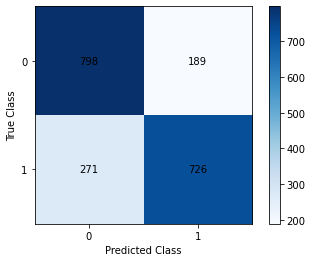

In [32]:
conf_mat_train = confusion_matrix(y_train, y_pred_train2)
conf_mat_test = confusion_matrix(y_test, y_pred_test2)

print("Training Confusion Matrix")
confusion_matrix_plot(conf_mat_train)
print(f"Training Precision: {round(precision_score(y_train, y_pred_train),4)} Training Recall: {round(recall_score(y_train, y_pred_train),4)}")
print(classification_report(y_train, y_pred_train2, target_names=target_names))

Test Confusion Matrix
Test Precision: 0.7637 Test Recall: 0.741
              precision    recall  f1-score   support

    Fail (0)       0.75      0.77      0.76       817
 Success (1)       0.76      0.74      0.75       807

    accuracy                           0.76      1624
   macro avg       0.76      0.76      0.76      1624
weighted avg       0.76      0.76      0.76      1624



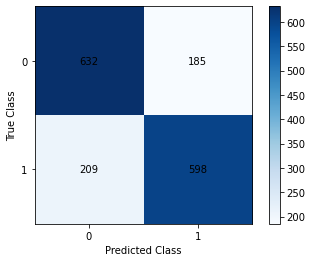

In [33]:
print("Test Confusion Matrix")
confusion_matrix_plot(conf_mat_test)
print(f"Test Precision: {round(precision_score(y_test, y_pred_test2),4)} Test Recall: {round(recall_score(y_test, y_pred_test2),4)}")
print(classification_report(y_test, y_pred_test2, target_names=target_names))

## Linear SVC

In [34]:
#LinearSVC Model
clf3 = LinearSVC(random_state=0)

clf3.fit(X_train, y_train)
y_pred_train3 = clf3.predict(X_train)
y_pred_test3 = clf3.predict(X_test)

print("Training Accuracy:", clf3.score(X_train, y_train))
print("Test Accuracy:", clf3.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train3, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test3, target_names=target_names))

Training Accuracy: 0.7933467741935484
Test Accuracy: 0.7660098522167488
Training               precision    recall  f1-score   support

    Fail (0)       0.79      0.80      0.79       987
 Success (1)       0.80      0.79      0.79       997

    accuracy                           0.79      1984
   macro avg       0.79      0.79      0.79      1984
weighted avg       0.79      0.79      0.79      1984

Test               precision    recall  f1-score   support

    Fail (0)       0.77      0.75      0.76       817
 Success (1)       0.76      0.78      0.77       807

    accuracy                           0.77      1624
   macro avg       0.77      0.77      0.77      1624
weighted avg       0.77      0.77      0.77      1624



## Logistic Regression

In [35]:
clf4  = LogisticRegression()

clf4.fit(X_train, y_train)
y_pred_train4 = clf4.predict(X_train)
y_pred_test4 = clf4.predict(X_test)

print("Training Accuracy:", clf4.score(X_train, y_train))
print("Test Accuracy:", clf4.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train4, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test4, target_names=target_names))

Training Accuracy: 0.7903225806451613
Test Accuracy: 0.7653940886699507
Training               precision    recall  f1-score   support

    Fail (0)       0.78      0.81      0.79       987
 Success (1)       0.80      0.77      0.79       997

    accuracy                           0.79      1984
   macro avg       0.79      0.79      0.79      1984
weighted avg       0.79      0.79      0.79      1984

Test               precision    recall  f1-score   support

    Fail (0)       0.77      0.76      0.77       817
 Success (1)       0.76      0.77      0.77       807

    accuracy                           0.77      1624
   macro avg       0.77      0.77      0.77      1624
weighted avg       0.77      0.77      0.77      1624



## AdaBoost

In [36]:
clf5  = AdaBoostClassifier(n_estimators=100)

clf5.fit(X_train, y_train)
y_pred_train5 = clf5.predict(X_train)
y_pred_test5 = clf5.predict(X_test)

print("Training Accuracy:", clf5.score(X_train, y_train))
print("Test Accuracy:", clf5.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train5, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test5, target_names=target_names))

Training Accuracy: 0.8125
Test Accuracy: 0.750615763546798
Training               precision    recall  f1-score   support

    Fail (0)       0.80      0.83      0.82       987
 Success (1)       0.83      0.79      0.81       997

    accuracy                           0.81      1984
   macro avg       0.81      0.81      0.81      1984
weighted avg       0.81      0.81      0.81      1984

Test               precision    recall  f1-score   support

    Fail (0)       0.75      0.75      0.75       817
 Success (1)       0.75      0.75      0.75       807

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



## Gradient Boost

In [37]:
clf6  = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)

clf6.fit(X_train, y_train)
y_pred_train6 = clf6.predict(X_train)
y_pred_test6 = clf6.predict(X_test)

print("Training Accuracy:", clf6.score(X_train, y_train))
print("Test Accuracy:", clf6.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train6, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test6, target_names=target_names))

Training Accuracy: 0.8200604838709677
Test Accuracy: 0.7610837438423645
Training               precision    recall  f1-score   support

    Fail (0)       0.81      0.83      0.82       987
 Success (1)       0.83      0.81      0.82       997

    accuracy                           0.82      1984
   macro avg       0.82      0.82      0.82      1984
weighted avg       0.82      0.82      0.82      1984

Test               precision    recall  f1-score   support

    Fail (0)       0.77      0.76      0.76       817
 Success (1)       0.76      0.77      0.76       807

    accuracy                           0.76      1624
   macro avg       0.76      0.76      0.76      1624
weighted avg       0.76      0.76      0.76      1624



## KNN

In [38]:
clf7  = KNeighborsClassifier(n_neighbors=7)

clf7.fit(X_train, y_train)
y_pred_train7 = clf7.predict(X_train)
y_pred_test7 = clf7.predict(X_test)

print("Training Accuracy:", clf7.score(X_train, y_train))
print("Test Accuracy:", clf7.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train7, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test7, target_names=target_names))

Training Accuracy: 0.7948588709677419
Test Accuracy: 0.7413793103448276
Training               precision    recall  f1-score   support

    Fail (0)       0.79      0.81      0.80       987
 Success (1)       0.80      0.78      0.79       997

    accuracy                           0.79      1984
   macro avg       0.80      0.79      0.79      1984
weighted avg       0.80      0.79      0.79      1984

Test               precision    recall  f1-score   support

    Fail (0)       0.75      0.73      0.74       817
 Success (1)       0.73      0.75      0.74       807

    accuracy                           0.74      1624
   macro avg       0.74      0.74      0.74      1624
weighted avg       0.74      0.74      0.74      1624



## Hard Voting

In [39]:
eclf = VotingClassifier(
    estimators=[('rf', clf),('nn', clf2),('svc',clf3),('lr',clf4),('ada',clf5),('gb',clf6),('knn',clf7)],
    voting='hard')

eclf.fit(X_train, y_train)
y_pred_traine = eclf.predict(X_train)
y_pred_teste = eclf.predict(X_test)

print("Training Accuracy:", eclf.score(X_train, y_train))
print("Test Accuracy:", eclf.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_traine, target_names=target_names))
print("Test", classification_report(y_test, y_pred_teste, target_names=target_names))

Iteration 1, loss = 0.70677975
Validation score: 0.507538
Iteration 2, loss = 0.66555834
Validation score: 0.653266
Iteration 3, loss = 0.63387009
Validation score: 0.718593
Iteration 4, loss = 0.60608338
Validation score: 0.758794
Iteration 5, loss = 0.58075766
Validation score: 0.763819
Iteration 6, loss = 0.55731380
Validation score: 0.773869
Iteration 7, loss = 0.53489757
Validation score: 0.768844
Iteration 8, loss = 0.51602148
Validation score: 0.768844
Iteration 9, loss = 0.50133961
Validation score: 0.773869
Iteration 10, loss = 0.48869302
Validation score: 0.773869
Iteration 11, loss = 0.47894635
Validation score: 0.778894
Iteration 12, loss = 0.47089115
Validation score: 0.768844
Iteration 13, loss = 0.46439111
Validation score: 0.758794
Iteration 14, loss = 0.45850262
Validation score: 0.748744
Iteration 15, loss = 0.45368016
Validation score: 0.748744
Iteration 16, loss = 0.44872731
Validation score: 0.748744
Iteration 17, loss = 0.44490455
Validation score: 0.738693
Valida

## Soft Voting

In [40]:
#linearsvc cant predict probabilities
eclf2 = VotingClassifier(
    estimators=[('rf', clf),('nn', clf2),('lr',clf4),('ada',clf5),('gb',clf6),('knn',clf7)],
    voting='soft')

eclf2.fit(X_train, y_train)
y_pred_traine2 = eclf2.predict(X_train)
y_pred_teste2 = eclf2.predict(X_test)

print("Training Accuracy:", eclf2.score(X_train, y_train))
print("Test Accuracy:", eclf2.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_traine2, target_names=target_names))
print("Test", classification_report(y_test, y_pred_teste2, target_names=target_names))

Iteration 1, loss = 0.68784336
Validation score: 0.673367
Iteration 2, loss = 0.64471319
Validation score: 0.758794
Iteration 3, loss = 0.60788174
Validation score: 0.763819
Iteration 4, loss = 0.57658396
Validation score: 0.758794
Iteration 5, loss = 0.54838000
Validation score: 0.768844
Iteration 6, loss = 0.52561944
Validation score: 0.763819
Iteration 7, loss = 0.50621755
Validation score: 0.763819
Iteration 8, loss = 0.49255692
Validation score: 0.758794
Iteration 9, loss = 0.48165837
Validation score: 0.758794
Iteration 10, loss = 0.47358967
Validation score: 0.763819
Iteration 11, loss = 0.46665864
Validation score: 0.758794
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Training Accuracy: 0.8578629032258065
Test Accuracy: 0.7629310344827587
Training               precision    recall  f1-score   support

    Fail (0)       0.85      0.87      0.86       987
 Success (1)       0.87      0.84      0.86       997

    accuracy           

In [41]:
#y_prob = clf3.predict_proba(X_test)
#Column_prob = pd.DataFrame(index=df.columns, data=y_prob, columns=["Success", "Fail"])

#lets try soft voting using ensemble methods for one approach

## Testing on New Data

### Linear SVC

In [42]:
X = df.iloc[:-15, 0:85]
y = df["Class"]
y = y.iloc[:-15]

Xh = hf.iloc[:, 0:85]
yh = hf["Class"]

#LinearSVC Model
clfh = LinearSVC(random_state=0)

clfh.fit(X, y)
y_pred_trainh = clfh.predict(X)
y_pred_testh = clfh.predict(Xh)

print("Training Accuracy:", clfh.score(X, y))
print("Test Accuracy:", clfh.score(Xh, yh))

print("Training", classification_report(y, y_pred_trainh, target_names=target_names))
print("Test", classification_report(yh, y_pred_testh, target_names=target_names))

Training Accuracy: 0.8396238908753807
Test Accuracy: 0.9333333333333333
Training               precision    recall  f1-score   support

    Fail (0)       0.85      0.96      0.90      5748
 Success (1)       0.77      0.47      0.58      1803

    accuracy                           0.84      7551
   macro avg       0.81      0.71      0.74      7551
weighted avg       0.83      0.84      0.82      7551

Test               precision    recall  f1-score   support

    Fail (0)       0.93      1.00      0.97        14
 Success (1)       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15



C:\Users\sesa561203\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sesa561203\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sesa561203\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
hf['predicted_full'] = y_pred_testh
hf['predicted_training'] = clf3.predict(Xh)
hf

C:\Users\sesa561203\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sesa561203\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,administrative,advertising,agriculture,analytics,apparel,apps,artificial,audio,beverage,biotechnology,...,Founded Date,Industry Groups,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Type,Top 5 Investors,Class,predicted_full,predicted_training
Organization Name,,,,,,,,,,,,,,,,,,,,,
Manage My Co-op,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,nan,1,M&A,2014,Seed,[Starve Ups],0,0,0
VerbalCare,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Health Care, Information Technology, Software",1,M&A,2013,Grant,[MassChallenge],0,0,1
RealTargeting,0.0,0.567423,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Advertising, Internet Services, Sales and Mark...",1,M&A,2013,Seed,[Matthew Novick],0,0,0
Sleeker App Studios,0.0,0.000000,0.0,0.000000,0.0,0.73796,0.0,0.0,0.0,0.0,...,2013,"Apps, Mobile, Software",2,Private Equity,2018,Private Equity,[Sparksuite],1,0,1
ProMD,0.0,0.000000,0.0,0.000000,0.0,0.63846,0.0,0.0,0.0,0.0,...,2013,"Apps, Health Care, Software",2,M&A,2014,Seed,"[Healthbox, BoomStartup]",0,0,0
CloudPress,0.0,0.505051,0.0,0.407692,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Advertising, Data and Analytics, Sales and Mar...",1,M&A,2013,Non-equity Assistance,[Flat6Labs],0,0,0
HybridSite Web Services,0.0,0.000000,0.0,0.300154,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Content and Publishing, Data and Analytics, De...",1,M&A,2013,Seed,[LightHouse Ohio],0,0,0
Levy Acquisition,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Financial Services, Lending and Investments",1,Seed,2013,Seed,[Jumpstart Ventures],0,0,0
Domain Media,0.0,0.482867,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Advertising, Internet Services, Media and Ente...",1,NaN,2014,Equity Crowdfunding,,0,0,1
